In [1]:
from fastai.vision.all import *
from duckduckgo_search import DDGS
from PIL import Image
import requests
from pathlib import Path

Aim for at least 30 images per class to improve model performance.

In [2]:
# Function to search for images
def search_images(query, max_results=30):
    with DDGS() as ddgs:
        results = ddgs.images(query, max_results=max_results)
        return [result['image'] for result in results]

In [3]:
# Function to download images
def download_images(dest, urls):
    for i, url in enumerate(urls):
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()  # Raise an error for bad responses
            img_path = dest / f'image_{i}.jpg'
            with open(img_path, 'wb') as f:
                f.write(response.content)
        except Exception as e:
            print(f"Failed to download {url}: {e}")

Aim for at least 30 images per class to improve model performance.

In [4]:
# Bear types and directory setup
bear_types = ['grizzly', 'black', 'teddy']
path = Path('bears')

if not path.exists():
    path.mkdir()

for bear in bear_types:
    dest = path / bear
    dest.mkdir(exist_ok=True)
    print(f"Searching images for: {bear} bear")
    
    # Search and download images
    results = search_images(f'{bear} bear', max_results=30)
    download_images(dest, urls=results)

Searching images for: grizzly bear
Failed to download https://www.publicdomainpictures.net/pictures/240000/velka/grizzly-bear-portrait-1511961987XRY.jpg: 403 Client Error: Forbidden for url: https://www.publicdomainpictures.net/pictures/240000/velka/grizzly-bear-portrait-1511961987XRY.jpg
Failed to download http://bearlegend.com/wp-content/uploads/2012/03/grizzlyBear_photofurl.jpeg: 406 Client Error: Not Acceptable for url: http://bearlegend.com/wp-content/uploads/2012/03/grizzlyBear_photofurl.jpeg
Failed to download https://wallup.net/wp-content/uploads/2016/01/30094-bears-nature-animals-Grizzly_bear-Grizzly_Bears.jpg: HTTPSConnectionPool(host='wallup.net', port=443): Read timed out.
Failed to download http://bearlegend.com/wp-content/uploads/2012/04/2390661788_951acb14b8_o.jpg: 406 Client Error: Not Acceptable for url: http://bearlegend.com/wp-content/uploads/2012/04/2390661788_951acb14b8_o.jpg
Failed to download https://www.publicdomainpictures.net/pictures/90000/velka/grizzly-bear-

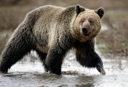

In [5]:
# Display one example image
example_image = (path / 'grizzly').glob('*.jpg')
for img_path in example_image:
    im = Image.open(img_path)
    im.thumbnail((128, 128))
    im.show()
    break  # Show only one image

To get our folder with image files

In [6]:
fns = get_image_files(path)
fns

(#74) [Path('bears/grizzly/image_27.jpg'),Path('bears/grizzly/image_11.jpg'),Path('bears/grizzly/image_13.jpg'),Path('bears/grizzly/image_24.jpg'),Path('bears/grizzly/image_6.jpg'),Path('bears/grizzly/image_18.jpg'),Path('bears/grizzly/image_4.jpg'),Path('bears/grizzly/image_3.jpg'),Path('bears/grizzly/image_29.jpg'),Path('bears/grizzly/image_10.jpg'),Path('bears/grizzly/image_0.jpg'),Path('bears/grizzly/image_15.jpg'),Path('bears/grizzly/image_8.jpg'),Path('bears/grizzly/image_14.jpg'),Path('bears/grizzly/image_19.jpg'),Path('bears/grizzly/image_2.jpg'),Path('bears/grizzly/image_12.jpg'),Path('bears/grizzly/image_23.jpg'),Path('bears/grizzly/image_22.jpg'),Path('bears/grizzly/image_25.jpg')...]

Get corrupt images

In [7]:
failed = verify_images(fns)
failed

(#1) [Path('bears/teddy/image_7.jpg')]

Removing all failed images and unlink them

In [8]:
failed.map(Path.unlink)

(#1) [None]

Turning our data into a DataLoader object

In [9]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

Command to give as our DataBlock object

In [10]:
dls = bears.dataloaders(path)

In [11]:
print(len(get_image_files(path)))  # Total images
for folder in path.ls(): 
    print(f"{folder.name}: {len(get_image_files(folder))} images")

73
grizzly: 25 images
black: 23 images
teddy: 25 images


Performing Data Augmentation

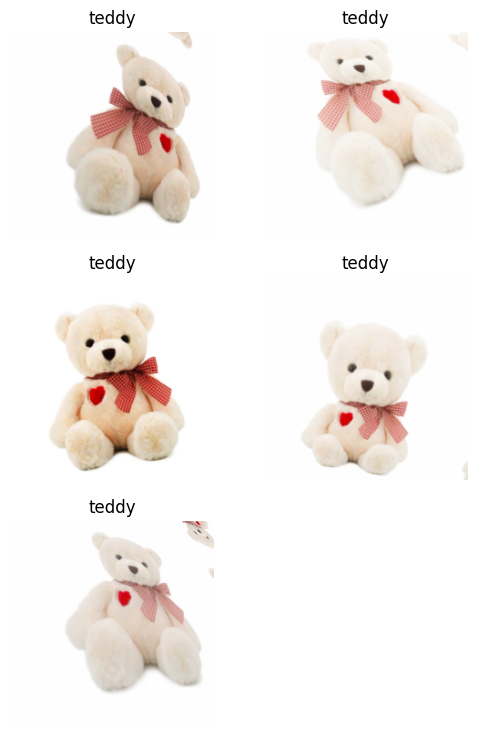

In [12]:
bears = bears.new(item_tfms=Resize(224), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=5, nrows=3, unique=True)

Create our learner and fine tune it

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.652142,3.390451,0.428571,00:04


epoch,train_loss,valid_loss,error_rate,time
0,1.395444,1.995417,0.428571,00:04
1,1.434149,0.545456,0.142857,00:04
2,1.091738,0.431326,0.142857,00:03
3,0.830997,0.461787,0.142857,00:04
